## 패키지 import

In [1]:
import datetime as dt
from pathlib import Path
import os

from datetime import datetime
import seaborn as sns

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

## 데이터 알기
- 데이터 파악하기
 - User ID : 1 ~ 6040 개수,
 - Moive ID : 1 ~ 3952 개수,
 - Ratings : 5star, 1~5 스타 사이의 개수.
 - Timestamp : utc 타임
 - 특징적으로 유저당 적어도 20개의 평가는 했다!

In [2]:
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/README', 'r')
while True:
    line = f.readline()
    if not line: break
#     print(line)
f.close()


## 데이터 로드

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## 데이터 분석 및 전처리

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


## time 컬럼 utc 시간으로 변경후 새롭게 추가해주기

In [6]:
data['UTC'] = data['Time']
data['UTC'] = pd.to_datetime(data['UTC'], unit='s')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   UserId  1000209 non-null  int32         
 1   ItemId  1000209 non-null  int32         
 2   Rating  1000209 non-null  int32         
 3   Time    1000209 non-null  int64         
 4   UTC     1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3), int64(1)
memory usage: 34.3 MB


- 유저 id 수와 item id (영화의 수) 를 알아보자

In [8]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

- 유저별(id가 같은)로 영화를 몇개씩 봤는지 확인

In [9]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [10]:
print(f"중앙값 : {user_length.median()}")
print(f"평균값 : {user_length.mean()}")
print(f"최소값 : {user_length.min()}")
print(f"최대값 : {user_length.max()}")
print(f"사분위 99%값 : {user_length.quantile(0.999)}")

중앙값 : 96.0
평균값 : 165.5975165562914
최소값 : 20
최대값 : 2314
사분위 99%값 : 1343.181000000005


- 99% 이상치 값은 이상치로 판단해 없애도록하자.
- 2314개를 단 리뷰 사람 출력  
짧은 시간에 여러 아이템을 평가한거보니 이상치라고 판단.  

In [11]:
long_session = user_length[user_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time,UTC
696969,4169,1268,5,965333392,2000-08-03 20:09:52
697168,4169,2617,4,965333392,2000-08-03 20:09:52
697185,4169,2628,4,965333392,2000-08-03 20:09:52
697219,4169,2653,4,965333392,2000-08-03 20:09:52
697275,4169,423,3,965333392,2000-08-03 20:09:52
...,...,...,...,...,...
697882,4169,3754,2,1024174347,2002-06-15 20:52:27
695702,4169,1413,3,1024175031,2002-06-15 21:03:51
697358,4169,494,4,1024175760,2002-06-15 21:16:00
695945,4169,1804,2,1024175783,2002-06-15 21:16:23


In [12]:
drop_index = user_length[user_length>1344].index
data.drop(index=drop_index, inplace=True)

- 리뷰 개수의 누적 합과 시각화

In [13]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

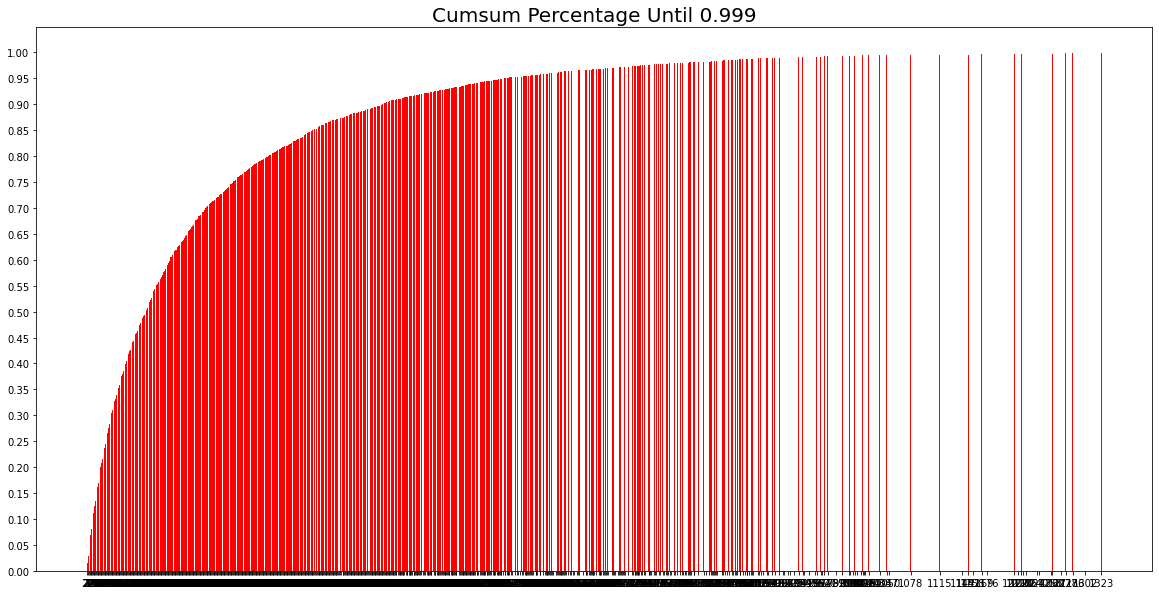

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 평점분포 확인
- 3점 이상이 대부분이므로, 3점 이상 데이터만 사용해도 될듯하다.

<function matplotlib.pyplot.show(close=None, block=None)>

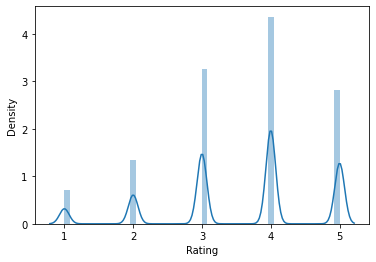

In [15]:
sns.distplot(data['Rating'])
plt.show

In [16]:
origin_Rating = data['Rating']
print(len(origin_Rating))
change_Rating = data[data['Rating']>=3]
print(len(change_Rating))

1000203
836472


In [17]:
data = data[data['Rating']>=3]
data

,UserId,ItemId,Rating,Time,UTC
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


### data cleansing

In [18]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
# 함수() -> '함수 주석'
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [19]:
data = cleanse_recursive(data, shortest=3, least_click=5)
data

,UserId,ItemId,Rating,Time,UTC
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


### train / valid / test split

In [20]:
data['UTC'].max(), data['UTC'].min()

(Timestamp('2003-02-28 17:49:50'), Timestamp('2000-04-25 23:05:32'))

- 약 3년간 데이터이므로, 마지막 한달을 test로, 그 전달을 vaild 셋으로 설정을 하자

In [21]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['UTC'].max()
    session_last_time = data.groupby('UserId')['UTC'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    return before_date, after_date

In [22]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [23]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["UTC"].min()}\n'
          f'\t Last Time : {data["UTC"].max()}\n')

In [24]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 769526
	 Sessions: 5859
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-12-30 02:26:14

* valid Set Stats Info
	 Events: 25128
	 Sessions: 81
	 Items: 2775
	 First Time : 2000-05-05 17:20:21
	 Last Time : 2003-01-29 03:00:40

* test Set Stats Info
	 Events: 41129
	 Sessions: 98
	 Items: 2992
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



## train data 기준 인덱싱

In [25]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

In [26]:
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

- 데이터 저장

In [27]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Data Pileline

- 데이터별 인덱스 추가하기

In [28]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [29]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,UTC,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
36,1,1836,5,978300172,2000-12-31 22:02:52,5
3,1,3408,4,978300275,2000-12-31 22:04:35,6
7,1,2804,5,978300719,2000-12-31 22:11:59,7
47,1,1207,4,978300719,2000-12-31 22:11:59,8
0,1,1193,5,978300760,2000-12-31 22:12:40,9


In [30]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,UTC,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
36,1,1836,5,978300172,2000-12-31 22:02:52,5
3,1,3408,4,978300275,2000-12-31 22:04:35,6
7,1,2804,5,978300719,2000-12-31 22:11:59,7
47,1,1207,4,978300719,2000-12-31 22:11:59,8
0,1,1193,5,978300760,2000-12-31 22:12:40,9


In [32]:
iter_ex = iter(tr_data_loader)

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')


Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Modeling

- 평가 지표

In [33]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

- 모델 구성

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

## 모델 하이퍼 파라미터 설정

In [36]:
args_1 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model_1 = create_model(args_1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


## Traing

In [37]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

### base line 
 - Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [38]:
train_model(model_1, args_1)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  33%|███▎      | 128/391 [00:36<01:14,  3.55it/s]


	 - Recall@20 epoch 1: 0.241699
	 - MRR@20    epoch 1: 0.061355



Evaluation:  33%|███▎      | 128/391 [00:34<01:10,  3.71it/s]


	 - Recall@20 epoch 2: 0.282959
	 - MRR@20    epoch 2: 0.077035



Evaluation:  33%|███▎      | 128/391 [00:34<01:10,  3.73it/s]


	 - Recall@20 epoch 3: 0.292480
	 - MRR@20    epoch 3: 0.083427



In [44]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [45]:
test_model(model_1, args_1, test)

Evaluation:  51%|█████     | 325/641 [01:27<01:25,  3.69it/s]

	 - Recall@20: 0.281683
	 - MRR@20: 0.080052



## IR을 바꾸면서 트레이닝 해보자
- IR = 0.0005

In [46]:
args_2 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.0005, epochs=3, k=20)
model_2 = create_model(args_2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [47]:
train_model(model_2, args_2)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  33%|███▎      | 128/391 [00:36<01:15,  3.48it/s]


	 - Recall@20 epoch 1: 0.164551
	 - MRR@20    epoch 1: 0.041221



Evaluation:  33%|███▎      | 128/391 [00:35<01:12,  3.62it/s]


	 - Recall@20 epoch 2: 0.247070
	 - MRR@20    epoch 2: 0.063846



Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.69it/s]


	 - Recall@20 epoch 3: 0.271851
	 - MRR@20    epoch 3: 0.072595



In [48]:
test_model(model_2, args_2, test)

Evaluation:  51%|█████     | 325/641 [01:29<01:26,  3.63it/s]

	 - Recall@20: 0.252596
	 - MRR@20: 0.068516



- IR = 0.0001

In [49]:
args_3 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.0001, epochs=3, k=20)
model_3 = create_model(args_3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [50]:
train_model(model_3, args_3)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  33%|███▎      | 128/391 [00:38<01:18,  3.35it/s]


	 - Recall@20 epoch 1: 0.078247
	 - MRR@20    epoch 1: 0.015814



Evaluation:  33%|███▎      | 128/391 [00:38<01:18,  3.33it/s]


	 - Recall@20 epoch 2: 0.086304
	 - MRR@20    epoch 2: 0.017678



Evaluation:  33%|███▎      | 128/391 [00:38<01:18,  3.37it/s]


	 - Recall@20 epoch 3: 0.092773
	 - MRR@20    epoch 3: 0.020681



In [52]:
test_model(model_3, args_3, test)

Evaluation:  51%|█████     | 325/641 [01:37<01:34,  3.34it/s]

	 - Recall@20: 0.072981
	 - MRR@20: 0.015659



### 세 값(0.001, 0.005, 0.0001) 중에서는 IR = 0.005가 적당한듯 하다.
- loss 값과, Recall MRR 값이 오르락 내리락 하지 않고, 지속적으로 줄어 들었다.

### batch size를 줄이면서 테스트 해보자

- batch_size = 32

In [53]:
args_4 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.0005, epochs=3, k=20)
model_4 = create_model(args_4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      503850    
_________________________________________________________________
dropout_3 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (32, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [54]:
train_model(model_4, args_4)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  71%|███████▏  | 559/782 [01:28<00:35,  6.35it/s]


	 - Recall@20 epoch 1: 0.171791
	 - MRR@20    epoch 1: 0.041782



Evaluation:  71%|███████▏  | 559/782 [01:26<00:34,  6.47it/s]


	 - Recall@20 epoch 2: 0.223222
	 - MRR@20    epoch 2: 0.058497



Evaluation:  71%|███████▏  | 559/782 [01:25<00:34,  6.55it/s]


	 - Recall@20 epoch 3: 0.244298
	 - MRR@20    epoch 3: 0.065510



In [65]:
test_model(model_4, args_4, test)

Evaluation:  78%|███████▊  | 997/1282 [02:35<00:44,  6.41it/s]

	 - Recall@20: 0.224173
	 - MRR@20: 0.060936



- batch_size = 16

In [56]:
args_5 = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.0005, epochs=3, k=20)
model_5 = create_model(args_5)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(16, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      503850    
_________________________________________________________________
dropout_4 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (16, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [57]:
train_model(model_5, args_5)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  85%|████████▌ | 1331/1565 [02:05<00:22, 10.60it/s]


	 - Recall@20 epoch 1: 0.184072
	 - MRR@20    epoch 1: 0.044300



Evaluation:  85%|████████▌ | 1331/1565 [02:03<00:21, 10.79it/s]


	 - Recall@20 epoch 2: 0.218022
	 - MRR@20    epoch 2: 0.057240



Evaluation:  85%|████████▌ | 1331/1565 [02:02<00:21, 10.86it/s]


	 - Recall@20 epoch 3: 0.232626
	 - MRR@20    epoch 3: 0.062928



In [58]:
test_model(model_5, args_5, test)

Evaluation:  89%|████████▉ | 2290/2564 [03:31<00:25, 10.84it/s]

	 - Recall@20: 0.222353
	 - MRR@20: 0.060581



- batch size가 작으면 작을수록 성능은 좋아지지만 epoch당 걸리는 시간이 늘어나긴 한다.

## epoch을 좀더 늘려서 성능이 좋아지는지 살펴보자

In [60]:
args_6 = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.0005, epochs=10, k=20)
model_6 = create_model(args_6)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(16, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      503850    
_________________________________________________________________
dropout_6 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_6 (Dense)              (16, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [61]:
train_model(model_6, args_6)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  85%|████████▌ | 1331/1565 [02:05<00:22, 10.58it/s]


	 - Recall@20 epoch 1: 0.184260
	 - MRR@20    epoch 1: 0.045938



Evaluation:  85%|████████▌ | 1331/1565 [02:04<00:21, 10.73it/s]


	 - Recall@20 epoch 2: 0.223328
	 - MRR@20    epoch 2: 0.059312



Evaluation:  85%|████████▌ | 1331/1565 [02:02<00:21, 10.84it/s]


	 - Recall@20 epoch 3: 0.234035
	 - MRR@20    epoch 3: 0.064997



Evaluation:  85%|████████▌ | 1331/1565 [02:03<00:21, 10.82it/s]


	 - Recall@20 epoch 4: 0.240092
	 - MRR@20    epoch 4: 0.068401



Evaluation:  85%|████████▌ | 1331/1565 [02:02<00:21, 10.86it/s]


	 - Recall@20 epoch 5: 0.243849
	 - MRR@20    epoch 5: 0.069836



Evaluation:  85%|████████▌ | 1331/1565 [02:01<00:21, 10.94it/s]


	 - Recall@20 epoch 6: 0.245445
	 - MRR@20    epoch 6: 0.070346



Evaluation:  85%|████████▌ | 1331/1565 [02:02<00:21, 10.86it/s]


	 - Recall@20 epoch 7: 0.248497
	 - MRR@20    epoch 7: 0.071554



Evaluation:  85%|████████▌ | 1331/1565 [02:01<00:21, 10.98it/s]


	 - Recall@20 epoch 8: 0.247323
	 - MRR@20    epoch 8: 0.071759



Evaluation:  85%|████████▌ | 1331/1565 [02:02<00:21, 10.89it/s]


	 - Recall@20 epoch 9: 0.247652
	 - MRR@20    epoch 9: 0.070999



Evaluation:  85%|████████▌ | 1331/1565 [02:02<00:21, 10.86it/s]


	 - Recall@20 epoch 10: 0.247136
	 - MRR@20    epoch 10: 0.071489



In [62]:
test_model(model_6, args_6, test)

Evaluation:  89%|████████▉ | 2290/2564 [03:30<00:25, 10.89it/s]

	 - Recall@20: 0.236436
	 - MRR@20: 0.068537



In [63]:
args_7 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.0005, epochs=10, k=20)
model_7 = create_model(args_7)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(32, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      503850    
_________________________________________________________________
dropout_7 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_7 (Dense)              (32, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [64]:
train_model(model_7, args_7)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  71%|███████▏  | 559/782 [01:28<00:35,  6.32it/s]


	 - Recall@20 epoch 1: 0.173468
	 - MRR@20    epoch 1: 0.043647



Evaluation:  71%|███████▏  | 559/782 [01:26<00:34,  6.48it/s]


	 - Recall@20 epoch 2: 0.224788
	 - MRR@20    epoch 2: 0.058094



Evaluation:  71%|███████▏  | 559/782 [01:25<00:33,  6.56it/s]


	 - Recall@20 epoch 3: 0.241447
	 - MRR@20    epoch 3: 0.064347



Evaluation:  71%|███████▏  | 559/782 [01:25<00:33,  6.57it/s]


	 - Recall@20 epoch 4: 0.251230
	 - MRR@20    epoch 4: 0.069621



Evaluation:  71%|███████▏  | 559/782 [01:24<00:33,  6.63it/s]


	 - Recall@20 epoch 5: 0.256373
	 - MRR@20    epoch 5: 0.072866



Evaluation:  71%|███████▏  | 559/782 [01:24<00:33,  6.58it/s]


	 - Recall@20 epoch 6: 0.258441
	 - MRR@20    epoch 6: 0.075153



Evaluation:  71%|███████▏  | 559/782 [01:24<00:33,  6.63it/s]


	 - Recall@20 epoch 7: 0.261013
	 - MRR@20    epoch 7: 0.076838



Evaluation:  71%|███████▏  | 559/782 [01:25<00:34,  6.55it/s]


	 - Recall@20 epoch 8: 0.262746
	 - MRR@20    epoch 8: 0.077382



Evaluation:  71%|███████▏  | 559/782 [01:24<00:33,  6.61it/s]


	 - Recall@20 epoch 9: 0.262914
	 - MRR@20    epoch 9: 0.077227



Evaluation:  71%|███████▏  | 559/782 [01:24<00:33,  6.60it/s]


	 - Recall@20 epoch 10: 0.264479
	 - MRR@20    epoch 10: 0.078715



In [66]:
test_model(model_7, args_7, test)

Evaluation:  78%|███████▊  | 997/1282 [02:32<00:43,  6.52it/s]

	 - Recall@20: 0.250564
	 - MRR@20: 0.072395



- baseline + IR 0.01

In [67]:
args_8 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20)
model_8 = create_model(args_8)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_8 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_8 (Dense)              (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [68]:
train_model(model_8, args_8)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  33%|███▎      | 128/391 [00:35<01:12,  3.62it/s]


	 - Recall@20 epoch 1: 0.249146
	 - MRR@20    epoch 1: 0.067868



Evaluation:  33%|███▎      | 128/391 [00:35<01:12,  3.62it/s]


	 - Recall@20 epoch 2: 0.253540
	 - MRR@20    epoch 2: 0.070842



Evaluation:  33%|███▎      | 128/391 [00:35<01:12,  3.64it/s]


	 - Recall@20 epoch 3: 0.252319
	 - MRR@20    epoch 3: 0.070252



In [69]:
test_model(model_8, args_8, test)

Evaluation:  51%|█████     | 325/641 [01:30<01:28,  3.58it/s]

	 - Recall@20: 0.244135
	 - MRR@20: 0.063184



## 결과
- baseline = batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20  


|Model|Recall|MRR|
|:------------|---|---|
|baseline|0.281683|0.080052|
|baseline -> IR = 0.0005|0.252596|0.068516|
|baseline -> IR = 0.0001|0.072981|0.015659|
|IR = 0.0005 -> batch_size = 32|0.224173|0.060936|
|IR = 0.0005, batch_size = 32, epoch = 10|0.250564|0.072395|
|IR = 0.0005 -> batch_size = 16|0.222353|0.060581|
|IR = 0.0005, batch_size = 16, epoch = 10|0.236436|0.068537|

## 회고
- 이번 Ex는 movielens 데이터셋을 이용한 session based recommendation를 통해서 다음에 볼 영화를 예측하는 것이다.  
기존 실습과는 다른점이 SessionId가 UserId로, time이 UTCT 타임으로 되어있다는 점이다.

- UserId가 유저 한명이라고 가정한다음 데이터를 전처리 하였고, 한사람이 3년동안 약 1300건 이상 본 데이터는 이상치라고 생각해 제거해 주었고, rating이 1,2는 다시 보지 않을거라 생각해 제거를 해주었다.

- 과제를 하면서 이전 실습때 사용했던 변수명을 같이 사용했다. 그래서 train은 제대로 된것처럼 보였으나, test하는 과정에서 오류가 났다. 코드 상으로는 크게 잘못된 부분이 없어보여서 많이 헤맸지만, 변수명을 바꾼뒤 다시 실행해보지 제대로 돌아갔다. 실습과 과제에서 같은 변수명을 사용하는것을 자제해야 겠다.

- 평과 과정에서 MMR 과 Recall@k 지표를 사용 했었다. recall은 모델이 예측한 것중에서, 몇개의 정답이 있는지, MMR은 정답의 순서에 민감한 지표이다. 따라서 Recall의 결과가 높은것도 중요하지만, MMR의 값도 무시 못한다.  

- test_model로 돌린 결과는 baseline 모델이 제일 좋게 나왔지만, accuracy라던가, train_loss를 살펴보면 결과의 맨 마지막 모델이 좋게 나왔다. 이 결과를 가지고 적절하게 선택하는 기준을 다시 세워야 할듯 하다.